In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6
print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.2.0


In [0]:
##
## generate data - a simple sine
##
def generate_data(x_min, x_max, n_datapoints=300,
                  f1 = 10, f2=20, offset1 = 0, offset2=0.2, noise=0.1):
  x = np.linspace(x_min, x_max, n_datapoints)
  y = 0.5*np.sin(f1*(x-offset1))+0.2*sin(f2*(x-offset2))+noise*np.random.rand(n_datapoints)-0.5
  return x,y


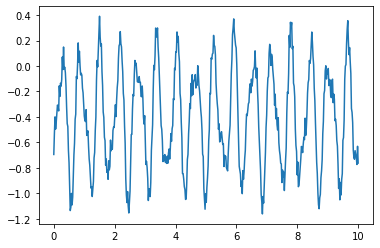

In [3]:
x,y = generate_data(x_min=0.0, x_max=10.0, n_datapoints=500,
                    f1=10, f2=17, offset1=0.1, offset2=0.3, noise=0.2)
plt.plot(x, y)
plt.show() 



In [0]:
##
## transform data into a sliding window of n points each
##

#use 50 points for the window width
sequence_length = 50 +1
sequence = []
for index in range(len(y) - sequence_length):
  sequence.append(y[index: index + sequence_length])
  
sequence = np.array(sequence)

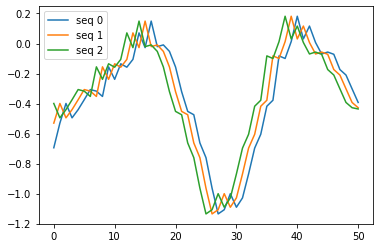

In [5]:
plt.plot(sequence[0], label='seq 0')
plt.plot(sequence[1], label='seq 1')
plt.plot(sequence[2], label='seq 2')

#one towards the end
#seq_no = len(sequence)-int(len(sequence)/10.0)
#plt.plot(sequence[seq_no], label='seq '+ str(seq_no))

plt.legend()
plt.show()


In [6]:
#use 80% for trainig, 20% for testing
train_index = round(0.8 * len(sequence))
print('train index {}'.format(train_index))

train = sequence[:int(train_index), :]
#np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test  = sequence[int(train_index):, :-1]
y_test  = sequence[int(train_index):, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

print(x_train.shape)


train index 359
(359, 50, 1)


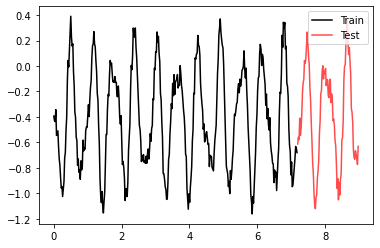

In [7]:
#
# plot train and test data
# (use the original dates in the y dataframe as x-values to get the dates on the x-axis right)
#
plt.plot(x[:train_index], y_train, label='Train', color='black',)
plt.plot(x[train_index:-sequence_length], y_test,  label='Test',  color='red', alpha=0.7)

plt.legend()
plt.show()

In [8]:
###
### build the model
###

model = tf.keras.Sequential()

model.add(layers.LSTM(units=50, input_shape=(sequence_length-1,1), return_sequences=True ))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))
model.add(layers.Activation('linear'))

model.compile(loss='mse', optimizer='adam')

###
### fit model
###
history = model.fit(x_train,y_train, batch_size=256, epochs=500, validation_split=0.05)

Epoch 1/500
2/2 [==============================] - 1s 294ms/step - loss: 0.3028 - val_loss: 0.3175
Epoch 2/500
2/2 [==============================] - 0s 19ms/step - loss: 0.2270 - val_loss: 0.2164
Epoch 3/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1838 - val_loss: 0.1470
Epoch 4/500
2/2 [==============================] - 0s 23ms/step - loss: 0.1745 - val_loss: 0.1351
Epoch 5/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1560 - val_loss: 0.1405
Epoch 6/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1409 - val_loss: 0.1423
Epoch 7/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1303 - val_loss: 0.1342
Epoch 8/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1219 - val_loss: 0.1196
Epoch 9/500
2/2 [==============================] - 0s 22ms/step - loss: 0.1090 - val_loss: 0.0972
Epoch 10/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0961 - val_loss: 0.0688
Epoch 11/500
2/2 [

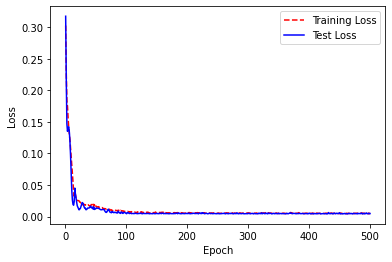

In [9]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [0]:
###
### Prediction
### sliding window, one step ahead
###

# start from the first window in the test data, i.e. sequence_length number of points
# with shape (sequence_length,1)
current_window = x_test[0]
prediction = []

for i in range(len(x_test)):
#for i in range(2):
    #LSTM cell expects 3D shape, add a new axis
    data_point = current_window[np.newaxis,:,:]
    
    #get a single number from the returned shape as the prediction
    pred = model.predict(data_point)[0,0]
    prediction.append(pred)
    # print(pred)
    
    #advance the input window to the LSTM cell, move the sequence one step up, add the prediction as the last number
    current_window = current_window[1:]
    current_window = np.insert(current_window,[sequence_length -1 -1], values=prediction[-1], axis=0)
    



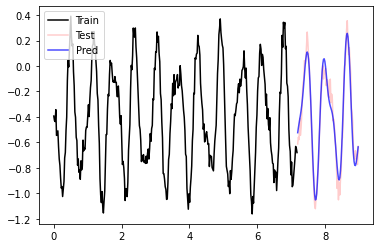

In [11]:
##
## show the prediction with the sample
##

plt.plot(x[:train_index], y_train, label='Train', color='black',)
plt.plot(x[train_index:-sequence_length], y_test,  label='Test',  color='red', alpha=0.2)
plt.plot(x[train_index:-sequence_length], prediction,  label='Pred',  color='blue', alpha=0.7)
plt.legend()
plt.show()

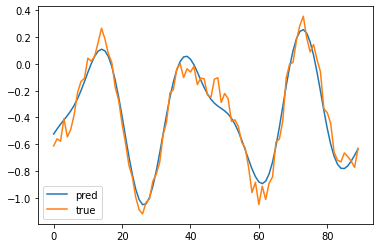

In [12]:
#
# zoom in on prediction 
#

plt.plot(prediction, label='pred')
plt.plot(y_test, label='true')
plt.legend()
plt.show()
